In [1]:
!pip install nengo --quiet
!pip install nengo-dl --quiet
!pip install nengo-loihi --quiet
!pip install nengo-extras==0.5.0 --quiet
!pip install nengo-gui --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.3/535.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 843.7/843.7 kB 9.6 MB/s eta 0:00:00


Question anwering model (representing sematic pointer architecture)

In [3]:
# Setup the environment
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import nengo
from nengo.spa import Vocabulary

In [4]:
dim = 20  # Number of dimensions
n_neurons = 300  # Number of neurons in population
n_conv = 70  # Number of neurons per dimension in bind/unbind populations

rng = np.random.RandomState(0)
vocab = Vocabulary(dimensions=dim, rng=rng, max_similarity=0.1)
model = nengo.Network(label="Question Answering", seed=7)

with model:
    # Ensembles
    ens_A = nengo.Ensemble(n_neurons=n_neurons, dimensions=dim, label="A")
    ens_B = nengo.Ensemble(n_neurons=n_neurons, dimensions=dim, label="B")
    ens_C = nengo.Ensemble(n_neurons=n_neurons, dimensions=dim, label="C")
    ens_D = nengo.Ensemble(n_neurons=n_neurons, dimensions=dim, label="D")
    ens_E = nengo.Ensemble(n_neurons=n_neurons, dimensions=dim, label="E")

    # Creating the bind network
    net_bind = nengo.networks.CircularConvolution(n_neurons=n_conv, dimensions=dim)
    nengo.Connection(ens_A, net_bind.A)
    nengo.Connection(ens_B, net_bind.B)
    nengo.Connection(net_bind.output, ens_D)

    # Creating the Unbind network
    net_unbind = nengo.networks.CircularConvolution(
        n_neurons=n_conv, dimensions=dim, invert_a=True
    )
    nengo.Connection(ens_C, net_unbind.A)
    nengo.Connection(ens_D, net_unbind.B)
    nengo.Connection(net_unbind.output, ens_E)

    # Getting semantic pointer values
    CIRCLE = vocab.parse("CIRCLE").v
    BLUE = vocab.parse("BLUE").v
    RED = vocab.parse("RED").v
    SQUARE = vocab.parse("SQUARE").v
    ZERO = [0] * dim

    # Function for providing color input
    def color_input(t):
        if (t // 0.5) % 2 == 0:
            return RED
        return BLUE

    # Function for providing shape input
    def shape_input(t):
        if (t // 0.5) % 2 == 0:
            return CIRCLE
        return SQUARE

    # Function for providing the cue
    def cue_input(t):
        sequence = [ZERO, CIRCLE, RED, ZERO, SQUARE, BLUE]
        idx = int((t // (1.0 / len(sequence))) % len(sequence))
        return sequence[idx]

    # Defining inputs
    input_A = nengo.Node(output=color_input, size_out=dim, label="Input A")
    input_B = nengo.Node(output=shape_input, size_out=dim, label="Input B")
    input_C = nengo.Node(output=cue_input, size_out=dim, label="Input C")

    # Connecting input to ensembles
    nengo.Connection(input_A, ens_A)
    nengo.Connection(input_B, ens_B)
    nengo.Connection(input_C, ens_C)

In [5]:
with model:
    A_probe = nengo.Probe(ens_A, synapse=0.03)
    B_probe = nengo.Probe(ens_B, synapse=0.03)
    C_probe = nengo.Probe(ens_C, synapse=0.03)
    D_probe = nengo.Probe(ens_D, synapse=0.03)
    E_probe = nengo.Probe(ens_E, synapse=0.03)

In [6]:
with nengo.Simulator(model) as sim:  # Create the simulator
    sim.run(3.0)  # Run it for 3 seconds

ERROR:nengo.cache:Decoder cache index corrupted. Reinitializing cache.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/nengo/cache.py", line 462, in __enter__
    self._load_index_file()
  File "/usr/local/lib/python3.10/dist-packages/nengo/cache.py", line 385, in _load_index_file
    with self.index_path.open("rb") as f:
  File "/usr/lib/python3.10/pathlib.py", line 1119, in open
    return self._accessor.open(self, mode, buffering, encoding, errors,
FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/nengo/decoders/index'


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 'time [s]')

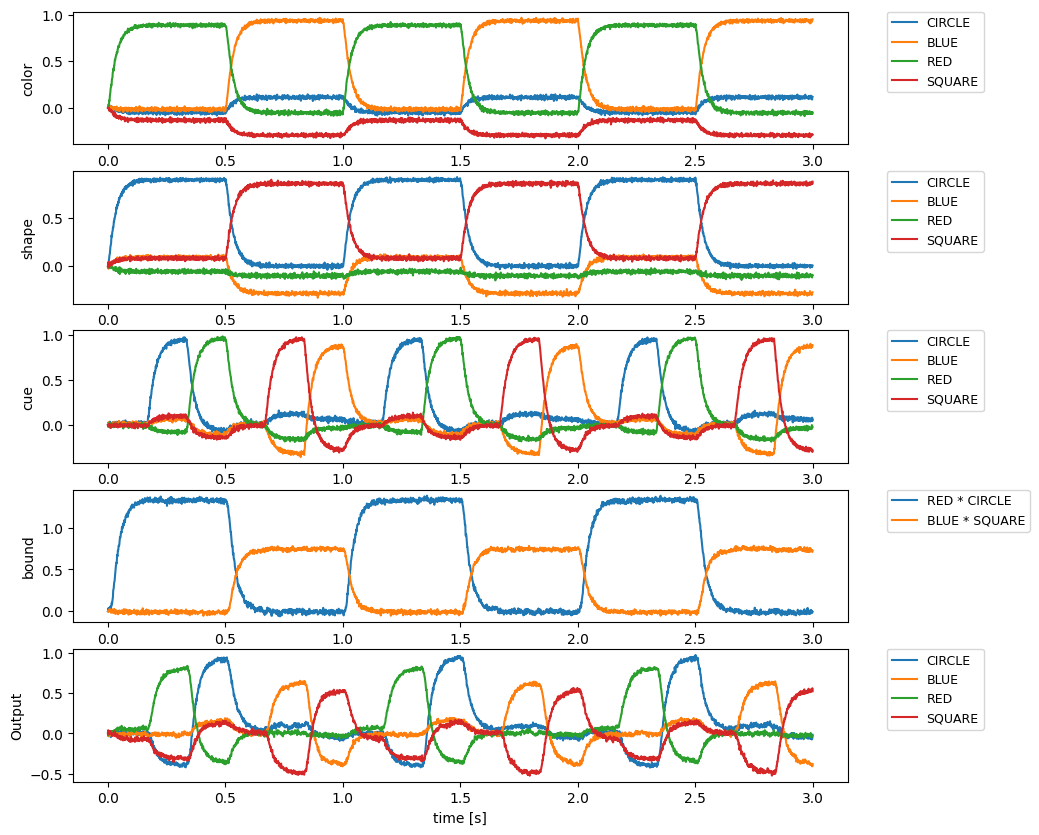

In [7]:
plt.figure(figsize=(10, 10))

plt.subplot(5, 1, 1)
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[A_probe], vocab))
plt.legend(vocab.keys, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=9)
plt.ylabel("color")

plt.subplot(5, 1, 2)
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[B_probe], vocab))
plt.legend(vocab.keys, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=9)
plt.ylabel("shape")

plt.subplot(5, 1, 3)
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[C_probe], vocab))
plt.legend(vocab.keys, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=9)
plt.ylabel("cue")

plt.subplot(5, 1, 4)
for pointer in ["RED * CIRCLE", "BLUE * SQUARE"]:
    plt.plot(sim.trange(), vocab.parse(pointer).dot(sim.data[D_probe].T), label=pointer)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=9)
plt.ylabel("bound")

plt.subplot(5, 1, 5)
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[E_probe], vocab))
plt.legend(vocab.keys, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=9)
plt.ylabel("Output")
plt.xlabel("time [s]")

In [8]:
from nengo import spa

dim = 32  # The dimensionality of the vectors
rng = np.random.RandomState(4)
vocab = Vocabulary(dimensions=dim, rng=rng, max_similarity=0.1)

# Adding semantic pointers to the vocabulary
CIRCLE = vocab.parse("CIRCLE")
BLUE = vocab.parse("BLUE")
RED = vocab.parse("RED")
SQUARE = vocab.parse("SQUARE")
ZERO = vocab.add("ZERO", [0] * dim)

# Create the spa.SPA network to which we can add SPA objects
model = spa.SPA(label="Question Answering", vocabs=[vocab])
with model:
    model.A = spa.State(dim)
    model.B = spa.State(dim)
    model.C = spa.State(dim)
    model.D = spa.State(dim)
    model.E = spa.State(dim)

    actions = spa.Actions(
        "D = A * B",
        "E = D * ~C",
    )

    model.cortical = spa.Cortical(actions)

    # Function for providing color input
    def color_input(t):
        if (t // 0.5) % 2 == 0:
            return "RED"
        return "BLUE"

    # Function for providing shape input
    def shape_input(t):
        if (t // 0.5) % 2 == 0:
            return "CIRCLE"
        return "SQUARE"

    # Function for providing the cue
    def cue_input(t):
        sequence = ["ZERO", "CIRCLE", "RED", "ZERO", "SQUARE", "BLUE"]
        idx = int((t // (1.0 / len(sequence))) % len(sequence))
        return sequence[idx]

    # Inputs
    model.input = spa.Input(A=color_input, B=shape_input, C=cue_input)

In [ ]:
from nengo_gui.ipython import IPythonViz

IPythonViz(model, "ch5-question.py.cfg")